 # Volatility Spillover Measures Using Generalized Variance Decomposition (GVD)



 Diebold and Yilmaz (2009, 2012) propose measuring volatility spillovers using the forecast error variance decomposition from a vector autoregressive (VAR) model.



 The VAR($p$) model is specified as:



 $$

 Y_t = \sum_{i=1}^p \Phi_i Y_{t-i} + \varepsilon_t,

 $$



 where $Y_t$ is an $N \times 1$ vector of realized variances, $\Phi_i$ are coefficient matrices, and $\varepsilon_t$ is a white noise error vector with covariance matrix $\Sigma$.



 The moving average representation is:



 $$

 Y_t = \sum_{i=0}^\infty A_i \varepsilon_{t-i}

 $$



 where matrices $A_i$ satisfy the recursion $A_i = \sum_{j=1}^p \Phi_j A_{i-j}$, with $A_0 = I_N$.



The forecast error variance decomposition quantifies the fraction of the $H$-step-ahead forecast error variance of variable $i$ attributable to shocks in variable $j$. The **Generalized Variance Decomposition (GVD)** method by Koop et al. (1996) and Pesaran and Shin (1998) is used because it is invariant to variable ordering.



 The GVD element is:



 $$

\theta^{g}_{ij}(H) = \frac{\sigma_{jj}^{-1} \sum_{h=0}^{H-1} \left( e_i' A_h \Sigma e_j \right)^2 }{

\sum_{h=0}^{H-1} \left( e_i' A_h \Sigma A_h' e_i \right) }

$$



 where $\sigma_{jj}$ is the variance of the error term for equation $j$, and $e_i$ is a selection vector with 1 in position $i$, zero elsewhere.



 Normalizing rows so their sum equals one gives:



$$

\tilde{\theta}^{g}_{ij}(H) = \frac{\theta^{g}_{ij}(H)}{\sum_{j=1}^N \theta^{g}_{ij}(H)}.

$$



 The **Total Spillover Index (TSI)** measures the contribution of spillovers to total forecast error variance:



$$

S^{g}(H) = \frac{\sum_{i=1}^N \sum_{j=1, j\neq i}^N \tilde{\theta}^{g}_{ij}(H)}{N} \times 100.

$$



Directional spillovers transmitted from market $i$ to others and received by market $i$ from others can also be computed from normalized GVD elements.

In [6]:
# Import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import KFold
import numpy as np


 ## Step 1: Load PIT-transformed realized variances and prepare VAR input

In [2]:
# --- Create dropdown ---
option_selector = widgets.Dropdown(
    options=['europe', 'australia'],
    value='europe',  # initial default
    description='Dataset:',
    disabled=False,
)

# --- Create button ---
button = widgets.Button(
    description="Load Dataset",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to load selected dataset',
    icon='check'  # (optional) FontAwesome icon
)

# --- Define button click handler ---
def on_button_click(b):
    global selected_option
    clear_output(wait=True)  # Clears previous output to keep it clean
    display(option_selector, button)  # Re-display widgets after clear
    
    selected_option = option_selector.value
    
# --- Attach button click handler ---
button.on_click(on_button_click)

# --- Display UI ---
display(option_selector, button)

Dropdown(description='Dataset:', index=1, options=('europe', 'australia'), value='australia')

Button(button_style='success', description='Load Dataset', icon='check', style=ButtonStyle(), tooltip='Click t…

In [3]:


pit_vars = pd.read_parquet(f"parquet_files/pit_transformed_variances_{selected_option}.parquet")
pit_vars.index = pd.to_datetime(pit_vars.index)

# Inspect the data
pit_vars.head()


Area,nsw,qld,sa,tas,vic
2009-07-01,-0.699212,-1.271926,-0.097437,-0.011362,-0.901846
2009-07-02,0.282052,1.040695,0.045462,-0.024856,0.442966
2009-07-03,-0.661619,-0.563926,-0.589925,-0.683880,-0.319200
2009-07-04,-0.720222,-0.947581,-0.711049,-0.065375,-0.551482
2009-07-05,-0.212486,-0.117435,-0.153986,-0.218300,0.083889


 ## Step 2: Fit MHAR model on realized variances





In [7]:
# Fit MHAR(1,7,30) with MultiTaskLassoCV

# --- Build MHAR regressors 
def create_mhar_lags(df):
    """
    Replicates the R HAR_ReV function:
      • lag-1 daily value
      • 7-day moving-average (lagged one day)
      • 30-day moving-average (lagged one day)
    Returns a dataframe [Y | lag1 | wavg | mavg] with matching index.
    """
    lag1  = df.shift(1).add_suffix("_lag1")
    wavg  = df.rolling(7 , min_periods=7).mean().shift(1).add_suffix("_wavg")
    mavg  = df.rolling(30, min_periods=30).mean().shift(1).add_suffix("_mavg")
    return pd.concat([df, lag1, wavg, mavg], axis=1).dropna()

mhar_data = create_mhar_lags(pit_vars)                                # drop first 30 obs
Y = mhar_data[pit_vars.columns]                                       # shape (T, N)
X = mhar_data.drop(columns=pit_vars.columns)                          # shape (T, 3N)

# --- Multi-task LASSO (joint CV across equations)
SEED = 12345
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
mt_lasso = MultiTaskLassoCV(cv=cv,
                            random_state=SEED,
                            max_iter=1_000_000,
                            tol=1e-10)                                # glmnet-style settings
mt_lasso.fit(X.values, Y.values)

B = mt_lasso.coef_        # shape N × 3N  – stacked [β¹ | β⁷ | β³⁰]
c = mt_lasso.intercept_   # length N       – intercepts


 ## Step 3: Compute moving average coefficient matrices $A_h$



 Calculate matrices $A_h$ for $h=0,\dots,H-1$, using the recursion:



$$

A_0 = I_N, \quad A_h = \sum_{j=1}^p \Phi_j A_{h-j} \quad \text{for } h>0,

$$



 where $\Phi_j$ are the VAR coefficient matrices.

In [8]:
# Static GVD + spillover table
N = Y.shape[1]
H = 2                      # include A(0) and A(1) exactly as in the R script
B_d, B_w, B_m = np.split(B, 3, axis=1)                            # each N×N  [#4]

# --- Φ₁ for MHAR: β¹ + β⁷/7 + β³⁰/30
Phi1 = B_d + B_w/7 + B_m/30                                       # N×N

# --- Residuals and Σ                                           [#3]
Y_hat = X @ B.T + c                 # implicit broadcast of intercept
U = Y.values - Y_hat
Sigma = U.T @ U / U.shape[0]                                      
sigma_diag_inv = np.diag(1/np.diag(Sigma))

# --- A(0)=I , A(1)=Φ₁                                             [#4]
A = [np.eye(N), Phi1]




 ## Step 4: Compute Generalized Variance Decomposition matrix $\Theta^g(H)$



 - Spillovers transmitted from market $i$:



$$

S^{g}_{.i}(H) = \frac{1}{N} \sum_{j=1, j \neq i}^N \tilde{\theta}^{g}_{ji}(H) \times 100

$$



- Spillovers received by market $i$:



$$

S^{g}_{i.}(H) = \frac{1}{N} \sum_{j=1, j \neq i}^N \tilde{\theta}^{g}_{ij}(H) \times 100

$$

In [10]:
# --- Generalised FEVD                                             [#5]
theta_g = np.zeros((N, N))
for i in range(N):
    e_i = np.zeros(N); e_i[i] = 1
    denom = sum(e_i @ A[h] @ Sigma @ A[h].T @ e_i for h in range(H))
    for j in range(N):
        e_j = np.zeros(N); e_j[j] = 1
        numer = sum((e_i @ A[h] @ Sigma @ e_j)**2 for h in range(H))
        theta_g[i, j] = sigma_diag_inv[j, j] * numer / denom

theta_g_norm = theta_g / theta_g.sum(axis=1, keepdims=True)

# --- Total & directional spillovers                              [#6]
TSI = 100 * (theta_g_norm.sum() - np.trace(theta_g_norm)) / N
spill_mat = theta_g_norm * 100                                     # %
to_ = spill_mat.sum(axis=0) - np.diag(spill_mat)
from_ = spill_mat.sum(axis=1) - np.diag(spill_mat)
net_ = to_ - from_

spill_tbl = pd.DataFrame(spill_mat, index=pit_vars.columns, columns=pit_vars.columns)
spill_tbl["Directional FROM others"] = from_
spill_tbl.loc["Directional TO others"] = list(to_) + [to_.sum()]
spill_tbl.loc["NET Directional"]      = list(net_) + [np.nan]

display(spill_tbl.round(2))
print(f"Total Spillover Index (TSI) = {TSI:.2f}%")

Area,nsw,qld,sa,tas,vic,Directional FROM others
Area,,,,,,
nsw,40.11,18.60,18.34,9.00,13.95,59.89
qld,26.10,59.20,3.43,1.92,9.35,40.80
sa,21.37,2.70,49.59,4.19,22.14,50.41
tas,14.47,1.83,6.35,65.56,11.80,34.44
vic,15.07,6.67,21.84,7.70,48.72,51.28
Directional TO others,77.00,29.79,49.96,22.82,57.25,236.81
NET Directional,17.11,-11.01,-0.45,-11.62,5.97,NaN


Total Spillover Index (TSI) = 47.36%


 ## Compute the same as before but with bootstraping (1.000 resamples)

In [13]:
# 🆕  Block bootstrap for MHAR-ReVar (fixed)
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np

n_boot  = 1000          # number of resamples
block   = 10            # days per block
SEED    = 12345
N       = pit_vars.shape[1]

def block_indices(n, size):
    n_blocks = int(np.ceil(n / size))
    starts   = np.random.randint(0, n - size + 1, n_blocks)
    idx      = np.concatenate([np.arange(s, s + size) for s in starts])[:n]
    return idx

def bs(seed):
    np.random.seed(seed)
    H = 2
    idx     = block_indices(len(pit_vars), block)
    sample  = pit_vars.iloc[idx].copy().reset_index(drop=True)    # ① keep time order
    dat     = create_mhar_lags(sample)

    Yb = dat[pit_vars.columns].values
    Xb = dat.drop(columns=pit_vars.columns).values

    mtl = MultiTaskLassoCV(cv=5, random_state=seed,
                           max_iter=1_000_000, tol=1e-10)
    mtl.fit(Xb, Yb)

    B_d, B_w, B_m = np.split(mtl.coef_, 3, axis=1)
    Phi1 = B_d + B_w/7 + B_m/30                    # not used for H=1 FEVD now
    c    = mtl.intercept_

    Ub   = Yb - Xb @ mtl.coef_.T - c               # residuals
    Sg   = np.cov(Ub.T)                            # Σ
    inv  = np.diag(1 / np.diag(Sg))                # Σ⁻ on diag

    # -------- FEVD, H = 1, A0 = I  ----------------------------- ②
    theta = np.zeros((N, N))
    for i in range(N):
        ei    = np.zeros(N); ei[i] = 1
        denom = sum(ei @ np.eye(N) @ Sg @ np.eye(N).T @ ei      # h = 0 term
                    if h == 0 else
                    ei @ Phi1 @ Sg @ Phi1.T @ ei                # h = 1 term
                    for h in range(H))                
        for j in range(N):
            ej = np.zeros(N); ej[j] = 1
            numer = sum((ei @ (np.eye(N) if h == 0 else Phi1) @ Sg @ ej)**2
                         for h in range(H))
            theta[i, j] = inv[j, j] * numer / denom
    theta /= theta.sum(axis=1, keepdims=True)

    tsi = 100 * (theta.sum() - np.trace(theta)) / N
    return theta, tsi

# -- run the bootstrap ---------------------------------------------
seeds = np.random.randint(0, 1_000_000, n_boot)
results = Parallel(n_jobs=-1)(delayed(bs)(s) for s in tqdm(seeds))

theta_bs = np.stack([r[0] for r in results])
tsi_bs   = np.array([r[1] for r in results])

theta_mu = theta_bs.mean(0) * 100
theta_se = theta_bs.std(0)  * 100
TSI_mu, TSI_se = tsi_bs.mean(), tsi_bs.std()

print(f"Bootstrapped TSI = {TSI_mu:.2f} ± {TSI_se:.2f}")

# -------- formatted spillover table with ±SE ----------------------
tbl = pd.DataFrame(index=pit_vars.columns, columns=pit_vars.columns)
for i in range(N):
    for j in range(N):
        tbl.iloc[i, j] = f"{theta_mu[i, j]:.2f} ± {theta_se[i, j]:.2f}"

to_mu   = theta_mu.sum(1) - np.diag(theta_mu)
from_mu = theta_mu.sum(0) - np.diag(theta_mu)
net_mu  = to_mu - from_mu

to_se   = (theta_bs.sum(2) - np.einsum('ijk->ij', theta_bs)).std(0) * 100
from_se = (theta_bs.sum(1) - np.einsum('ijk->ik', theta_bs)).std(0) * 100
net_se  = np.sqrt(to_se**2 + from_se**2)

tbl["Directional FROM others"] = [f"{m:.2f} ± {s:.2f}" for m, s in zip(from_mu, from_se)]
tbl.loc["Directional TO others"] = [f"{m:.2f} ± {s:.2f}" for m, s in zip(to_mu, to_se)] + [""]
tbl.loc["NET Directional"]       = [f"{m:.2f} ± {s:.2f}" for m, s in zip(net_mu, net_se)] + [""]

display(tbl)
tbl.to_parquet(f"parquet_files/volatility_spillovers_MHAR_LASSO_bootstrap_{selected_option}.parquet")


100%|██████████| 1000/1000 [40:30<00:00,  2.43s/it]


Bootstrapped TSI = 54.73 ± 1.14


Area,nsw,qld,sa,tas,vic,Directional FROM others
Area,,,,,,
nsw,36.12 ± 0.85,19.62 ± 0.83,18.02 ± 0.75,10.96 ± 0.65,15.27 ± 0.69,76.43 ± 0.00
qld,25.99 ± 0.98,51.09 ± 1.51,6.02 ± 0.72,4.85 ± 0.63,12.05 ± 1.05,37.97 ± 0.00
sa,20.05 ± 0.93,5.00 ± 0.64,43.41 ± 1.16,7.34 ± 0.72,24.20 ± 0.92,55.98 ± 0.00
tas,15.28 ± 0.90,4.73 ± 0.64,9.56 ± 0.80,53.64 ± 1.74,16.80 ± 0.98,34.95 ± 0.00
vic,15.11 ± 0.72,8.62 ± 0.84,22.38 ± 1.04,11.80 ± 0.91,42.08 ± 1.17,68.33 ± 0.00
Directional TO others,63.88 ± 0.00,48.91 ± 0.00,56.59 ± 0.00,46.36 ± 0.00,57.92 ± 0.00,
NET Directional,-12.55 ± 0.00,10.94 ± 0.00,0.61 ± 0.00,11.41 ± 0.00,-10.41 ± 0.00,


## Dynamic analysis

In [15]:
# --- Rolling TSI + directional spillovers   MHAR-ReVar (A0 & A1) -----------------
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV
from tqdm import tqdm
import pandas as pd
import numpy as np

window = 365
H      = 2

# ── 1) obtenemos α* una sola vez en TODA la muestra ------------------------------
alphas = np.logspace(-4, 1, 50)
cv_full = MultiTaskLassoCV(alphas=alphas, cv=5, max_iter=1_000_000, tol=1e-10)
cv_full.fit(X.values, Y.values)              # X, Y de la sección estática
best_alpha = cv_full.alpha_

# ── 2) contenedores --------------------------------------------------------------
dates, tsi_vals = [], []
to_list, from_list, net_list = [], [], []

# ── 3) bucle rolling -------------------------------------------------------------
for start in tqdm(range(len(pit_vars) - window + 1)):
    end   = start + window
    win   = pit_vars.iloc[start:end]

    lagdf = create_mhar_lags(win)
    if lagdf.empty:
        continue

    Yw = lagdf[win.columns].values
    Xw = lagdf.drop(columns=win.columns).values
    K  = Yw.shape[1]

    # ---- LASSO sin CV  ----------------------------------------------------------
    mtl = MultiTaskLasso(alpha=best_alpha, warm_start=False,
                         max_iter=50_000, tol=1e-4).fit(Xw, Yw)

    # ---- Σ ---------------------------------------------------------------------
    resid = Yw - Xw @ mtl.coef_.T - mtl.intercept_
    Sw    = np.cov(resid.T)
    inv   = np.diag(1 / np.diag(Sw))

    # ---- A(1) ------------------------------------------------------------------
    B_d, B_w, B_m = np.split(mtl.coef_, 3, axis=1)
    Phi1   = B_d + B_w/7 + B_m/30
    A_list = [np.eye(K), Phi1]                      # A0, A1

    # ---- FEVD (H = 2) ----------------------------------------------------------
    theta = np.zeros((K, K))
    for i in range(K):
        ei    = np.zeros(K); ei[i] = 1
        denom = sum(ei @ A_list[h] @ Sw @ A_list[h].T @ ei for h in range(H))
        for j in range(K):
            ej    = np.zeros(K); ej[j] = 1
            numer = sum((ei @ A_list[h] @ Sw @ ej)**2 for h in range(H))
            theta[i, j] = inv[j, j] * numer / denom
    theta /= theta.sum(axis=1, keepdims=True)

    # ---- Total & directional ---------------------------------------------------
    spill = theta * 100
    to_v    = spill.sum(0) - np.diag(spill)     # “to others from i”
    from_v  = spill.sum(1) - np.diag(spill)     # “from others to i”
    net_v   = to_v - from_v

    to_list.append(to_v)
    from_list.append(from_v)
    net_list.append(net_v)

    tsi_vals.append(100 * (theta.sum() - np.trace(theta)) / K)
    dates.append(lagdf.index[-1])

# ── 4) guardar resultados --------------------------------------------------------
idx  = pd.to_datetime(dates)
cols = pit_vars.columns        # nombres de los mercados

tsi_df   = pd.DataFrame({"TSI": tsi_vals}, index=idx)
to_df    = pd.DataFrame(to_list   , index=idx, columns=cols)
from_df  = pd.DataFrame(from_list , index=idx, columns=cols)
net_df   = pd.DataFrame(net_list  , index=idx, columns=cols)

tsi_df.to_parquet(
    f"parquet_files/rolling_tsi_mhar_revar_{selected_option}.parquet"
)
pd.concat(
    {"TO": to_df, "FROM": from_df, "NET": net_df},
    axis=1
).to_parquet(
    f"parquet_files/rolling_directional_revar_{selected_option}.parquet"
)



100%|██████████| 3166/3166 [00:18<00:00, 168.33it/s]


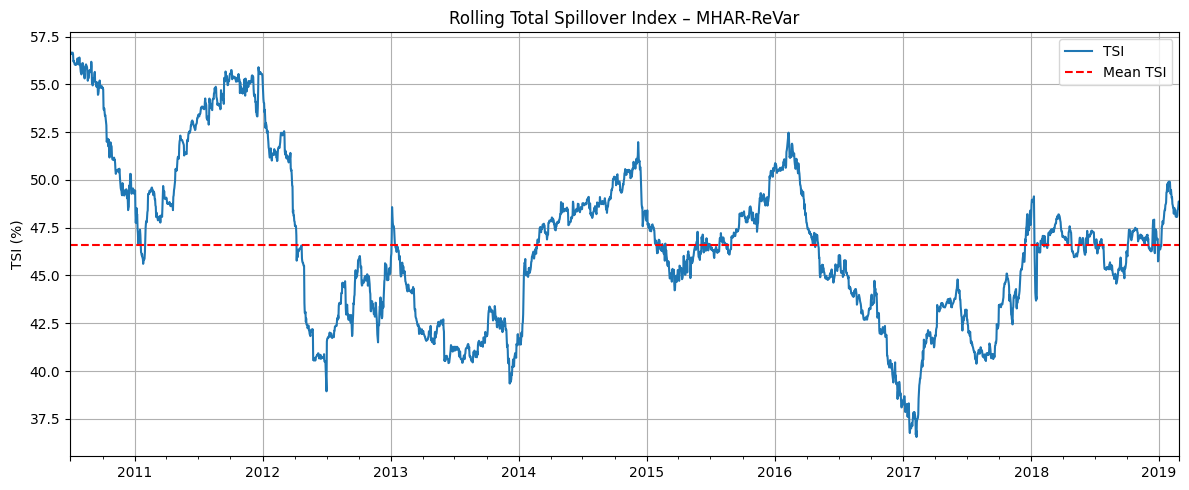

In [16]:
# -------- save & plot -------------------------------------------
tsi_df = pd.DataFrame({"TSI": tsi_vals}, index=dates)
tsi_df.to_parquet(
    f"parquet_files/rolling_tsi_mhar_revar_{selected_option}.parquet"
)

fig, ax = plt.subplots(figsize=(12, 5))
tsi_df["TSI"].plot(ax=ax, label="TSI")
ax.axhline(tsi_df["TSI"].mean(), ls="--", c="red", label="Mean TSI")
ax.set(title="Rolling Total Spillover Index – MHAR-ReVar", ylabel="TSI (%)")
ax.legend(); ax.grid(True); plt.tight_layout(); plt.show()


C:\Users\frolo\AppData\Local\Temp\ipykernel_6904\2193925116.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect = [0, .05, 1, 1])


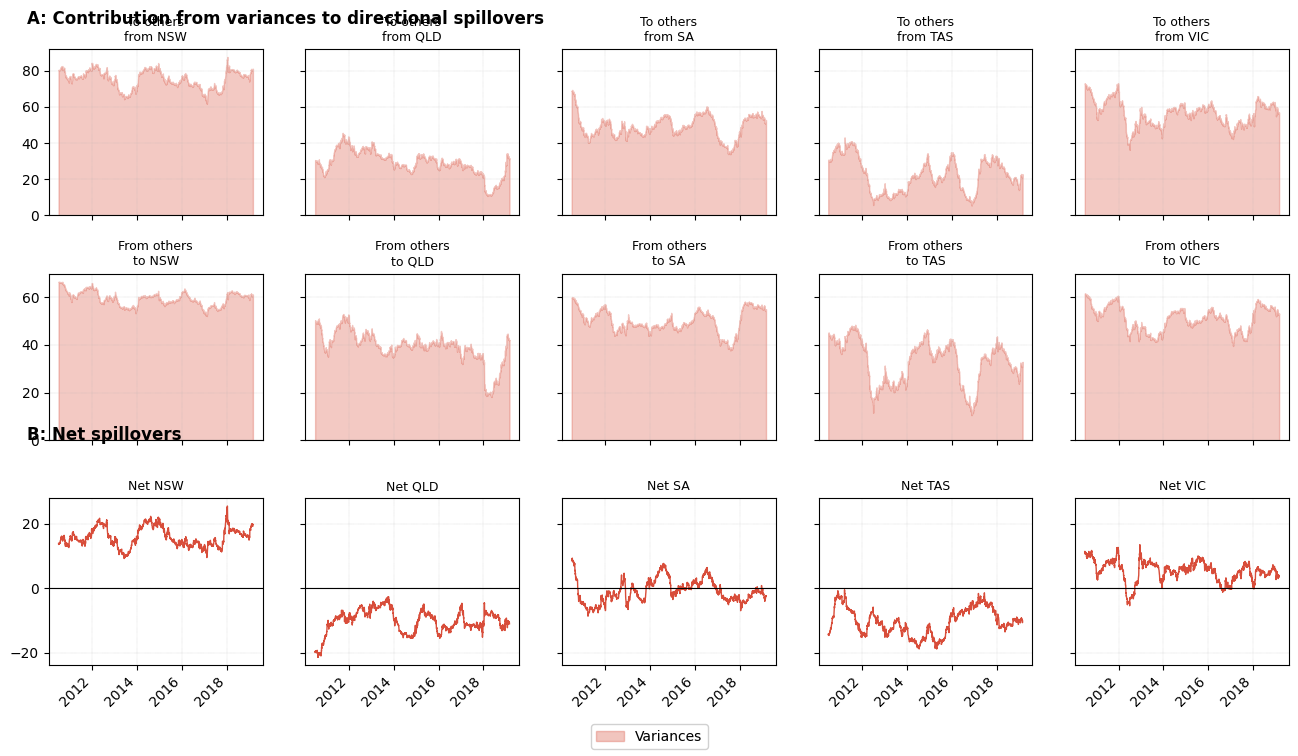

In [20]:
# ──────────────────────────────────────────────────────────────────────────────
#  GRID TO-/FROM-/NET  ── rolling MHAR-ReVar
#     • funciona con cualquier nº de mercados
# ──────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.dates   as mdates
import pandas  as pd
import numpy   as np
import math

# ------------------------------------------------------------------
# 1) datos
# ------------------------------------------------------------------
panel = pd.read_parquet(
    f"parquet_files/rolling_directional_revar_{selected_option}.parquet"
)                                # col-level-0: ["TO","FROM","NET"]

to_df, from_df, net_df = (panel[k] for k in ["TO", "FROM", "NET"])
markets                = to_df.columns.tolist()
n_mk                   = len(markets)
nicename = lambda s: s.upper()        # 'nsw' → 'NSW'


# ------------------------------------------------------------------
# 2) parámetros de diseño
# ------------------------------------------------------------------
col_chunk = 5                                # máx. columnas por “banda”
n_bands   = math.ceil(n_mk / col_chunk)      # bandas de 3 filas cada una

# figura
fig_w = 3.2 * min(col_chunk, n_mk)           # ancho aprox. 3.2 in por col.
fig_h = 8.0 * n_bands                        # 8 in por banda
fig , axes = plt.subplots(
    nrows = 3 * n_bands,
    ncols = col_chunk,
    figsize = (fig_w, fig_h),
    sharex = "row",
    sharey = "row",
    gridspec_kw = {"hspace": .35, "wspace": .20}
)

# Eje fecha
loc = mdates.YearLocator(base = 2)
fmt = mdates.DateFormatter("%Y")

# colores
col_var = "#d84d3a"
alpha   = .30

# ------------------------------------------------------------------
# 3) dibujar cada mercado en su grid-slot
# ------------------------------------------------------------------
for idx, mkt in enumerate(markets):
    name = nicename(mkt) 
    band   = idx // col_chunk          # banda 0,1,2…
    col    = idx %  col_chunk          # columna dentro de la banda
    rows   = np.arange(3) + band*3     # filas absolutas

    # TO ───────────────────────────────────────────────────────────────────────────
    ax_to = axes[rows[0], col]
    ax_to.fill_between(to_df.index, 0, to_df[mkt],
                    color=col_var, alpha=alpha,
                    label="Variances" if idx==0 else None)
    ax_to.set_title(f"To others\nfrom {name}", fontsize=9)
    ax_to.set_ylim(0, to_df.max().max()*1.05)
    ax_to.xaxis.set_major_locator(loc); ax_to.xaxis.set_major_formatter(fmt)
    ax_to.tick_params(axis="x", labelbottom=False)          # quita fechas duplicadas
    ax_to.grid(ls=":", lw=.3)

    # FROM ────────────────────────────────────────────────────────────────────────
    ax_fr = axes[rows[1], col]
    ax_fr.fill_between(from_df.index, 0, from_df[mkt],
                    color=col_var, alpha=alpha)
    ax_fr.set_title(f"From others\nto {name}", fontsize=9)
    ax_fr.set_ylim(0, from_df.max().max()*1.05)
    ax_fr.xaxis.set_major_locator(loc); ax_fr.xaxis.set_major_formatter(fmt)
    ax_fr.tick_params(axis="x", labelbottom=False)
    ax_fr.grid(ls=":", lw=.3)

    # NET ─────────────────────────────────────────────────────────────────────────
    ax_nt = axes[rows[2], col]
    ax_nt.plot(net_df.index, net_df[mkt], color=col_var, lw=1)
    ax_nt.axhline(0, color="black", lw=.8)
    ax_nt.set_title(f"Net {name}", fontsize=9)
    ax_nt.xaxis.set_major_locator(loc); ax_nt.xaxis.set_major_formatter(fmt)
    for lab in ax_nt.get_xticklabels():
        lab.set_rotation(45); lab.set_ha("right")
    ax_nt.grid(ls=":", lw=.3)

    # formato fechas solo en la fila NET
    ax_nt.xaxis.set_major_locator(loc)
    ax_nt.xaxis.set_major_formatter(fmt)
    for label in ax_nt.get_xticklabels():
        label.set_rotation(45); label.set_ha("right")

# ------------------------------------------------------------------
# 4) estética global
# ------------------------------------------------------------------
# leyenda (solo una)
handles, labels = axes[0,0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, ncol = 1, loc = "lower center", frameon = False)


row_B = 2              # fila donde empiezan los paneles Net
# leyenda centrada
fig.legend(handles, labels, ncol=1, loc="lower center",
           framealpha=.9, facecolor="white")

# encabezados
axes[0, 0].text(-0.1, 1.15,
                "A: Contribution from variances to directional spillovers",
                transform=axes[0, 0].transAxes,
                fontsize=12, fontweight="bold")

axes[row_B, 0].text(-0.1, 1.35, "B: Net spillovers",
                    transform=axes[row_B, 0].transAxes,
                    fontsize=12, fontweight="bold")





plt.tight_layout(rect = [0, .05, 1, 1])
plt.show()

# ------------------------------------------------------------------
# 5) guarda el panel completo (TO / FROM / NET)
# ------------------------------------------------------------------
panel.to_parquet(
    f"parquet_files/directional_spillovers_revar_panel_{selected_option}.parquet"
)

